In [1]:
import numpy as np # linear algebra
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from PIL import Image
import random
#Dependencies
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
#CNN
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import warnings
import os
import shutil
from PIL import ImageFile
warnings.simplefilter('error', Image.DecompressionBombWarning)
ImageFile.LOAD_TRUNCATED_IMAGES = True
from PIL import Image
Image.MAX_IMAGE_PIXELS = 1000000000
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Dense, Flatten, GlobalMaxPooling2D
from keras.callbacks import CSVLogger
#from livelossplot.keras import PlotLossesCallback
import efficientnet.keras as efn

from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="4,5"


In [4]:
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


In [5]:
TRAINING_LOGS_FILE = "training_logs.csv"
MODEL_SUMMARY_FILE = "model_summary.txt"

In [6]:
datasetFolderName='dataset'
MODEL_FILENAME="model_cv.h5"
sourceFiles=[]
classLabels=['Amphibolis','Background', 'Halophila', 'Posidonia']
def transferBetweenFolders(source, dest, splitRate):   
    global sourceFiles
    sourceFiles=os.listdir(source)
    if(len(sourceFiles)!=0):
        transferFileNumbers=int(len(sourceFiles)*splitRate)
        transferIndex=random.sample(range(0, len(sourceFiles)), transferFileNumbers)
        for eachIndex in transferIndex:
            shutil.move(source+str(sourceFiles[eachIndex]), dest+str(sourceFiles[eachIndex]))
    else:
        print("No file moved. Source empty!")
        
def transferAllClassBetweenFolders(source, dest, splitRate):
    for label in classLabels:
        transferBetweenFolders(datasetFolderName+'/'+source+'/'+label+'/', 
                               datasetFolderName+'/'+dest+'/'+label+'/', 
                               splitRate)


In [7]:
# First, check if test folder is empty or not, if not transfer all existing files to train
#transferAllClassBetweenFolders('test', 'train', 1.0)
# Now, split some part of train data into the test folders.
#transferAllClassBetweenFolders('train', 'test', 0.20)


In [8]:
X=[]
Y=[]

In [9]:
def prepareNameWithLabels(folderName):
    sourceFiles=os.listdir(datasetFolderName+'/train/'+folderName)
    for val in sourceFiles:
        X.append(val)
        if(folderName==classLabels[0]):
            Y.append(0)
        elif(folderName==classLabels[1]):
            Y.append(1)
        elif(folderName==classLabels[2]):
            Y.append(2)
        else:
            Y.append(3)

In [10]:
# Organize file names and class labels in X and Y variables
prepareNameWithLabels(classLabels[0])
prepareNameWithLabels(classLabels[1])
prepareNameWithLabels(classLabels[2]) 
prepareNameWithLabels(classLabels[3]) 


In [11]:
X=np.asarray(X)
Y=np.asarray(Y)

In [12]:
IMAGE_SIZE = 456
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE
#EPOCHS = 10
BATCH_SIZE = 32
#TEST_SIZE = 30

input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)

In [13]:
csv_logger = CSVLogger("training.csv", separator=',', append=False)

In [14]:
# learning rate

#activationFunction='relu'
def getModel():
    
    model = Sequential()
    efficient_net = efn.EfficientNetB5(weights='imagenet', include_top=False, input_shape=input_shape)
    #efficient_net.trainable = False
    for index, layer in enumerate(efficient_net.layers):
        if index < 761:
            layer.trainable = False

  
    model.add(efficient_net)
    #model.add(GlobalMaxPooling2D())
    model.add(Dense(1024, activation='relu'))
    model.add(Flatten())
    # if dropout_rate > 0:
    #     model.add(layers.Dropout(dropout_rate, name="dropout_out"))
    # model.add(layers.Dense(256, activation='relu', name="fc1"))
    model.add(Dense(4, activation='softmax')) #, name="output"
    model.compile(loss='categorical_crossentropy',
            optimizer=RMSprop(lr=0.0001),
            metrics=['accuracy'])

    with open(MODEL_SUMMARY_FILE,"w") as fh:
        model.summary(print_fn=lambda line: fh.write(line + "\n"))
       
    return model

In [15]:
def my_metrics(y_true, y_pred):
    accuracy=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred,average='weighted')
    f1Score=f1_score(y_true, y_pred, average='weighted') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    cm=confusion_matrix(y_true, y_pred)
    print(cm)
    return accuracy, precision, f1Score

In [16]:
# input image dimensions
img_rows, img_cols =  456, 456


In [17]:
train_path=datasetFolderName+'/train/'
validation_path=datasetFolderName+'/validation/'
test_path=datasetFolderName+'/test/'
model=getModel()

In [23]:
checkpoint = ModelCheckpoint("effee44.h5", monitor='accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='accuracy', min_delta=0, patience=10, verbose=1, mode='auto')


In [24]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
skf.get_n_splits(X, Y)
foldNum=0
for train_index, val_index in skf.split(X, Y):
    #First cut all images from validation to train (if any exists)
    transferAllClassBetweenFolders('validation', 'train', 1.0)
    foldNum+=1
    print("Results for fold",foldNum)
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]
    # Move validation images of this fold from train folder to the validation folder
    for eachIndex in range(len(X_val)):
        classLabel=''
        if(Y_val[eachIndex]==0):
            classLabel=classLabels[0]
        elif(Y_val[eachIndex]==1):
            classLabel=classLabels[1]
        elif(Y_val[eachIndex]==2):
            classLabel=classLabels[2]
        else:
            classLabel=classLabels[3]   
        #Then, copy the validation images to the validation folder
        shutil.move(datasetFolderName+'/train/'+classLabel+'/'+X_val[eachIndex], 
                    datasetFolderName+'/validation/'+classLabel+'/'+X_val[eachIndex])
        
    train_datagen = ImageDataGenerator(
                rescale=1./255,
        		zoom_range=0.20,
            	fill_mode="nearest"
                )
    validation_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)
        
    #Start ImageClassification Model
    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(img_rows, img_cols),
        batch_size=32,
        class_mode='categorical',
        subset='training')

    validation_generator = validation_datagen.flow_from_directory(
            validation_path,
            target_size=(img_rows, img_cols),
            batch_size=32,
            class_mode=None,  # only data, no labels
            shuffle=False)   
   
    # fit model
    history=model.fit_generator(train_generator, 
                        epochs=1000, callbacks = [checkpoint, early,csv_logger])
    
    
    
    predIdxs = model.predict_generator(validation_generator)
    predIdxs = np.argmax(predIdxs, axis=1)
        
    labels = validation_generator.labels
        
    # Calculate metrics and confusion matrices for the test images
    print(classification_report(labels, predIdxs, target_names=classLabels))
    print(confusion_matrix(labels, predIdxs))
    print("Normalized Confusion Matrix")
    C = confusion_matrix(labels, predIdxs)
    print( C / C.astype(np.float).sum(axis=1, keepdims=True) )
    
    
    
    #predictions = model.predict_generator(validation_generator, verbose=0)
    #yPredictions = np.argmax(predictions, axis=1)
    #true_classes = validation_generator.classes
    # evaluate validation performance
    print("****************************************")    
    #valAcc, valPrec, valFScore = my_metrics(true_classes, yPredictions)
    
    
    


Results for fold 1
Found 26198 images belonging to 4 classes.
Found 5230 images belonging to 4 classes.


/home/noman/anaconda3/envs/tensor2/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/1000
819/819 [==============================] - 1174s 1s/step - loss: 0.0945 - accuracy: 0.9882

Epoch 00001: accuracy improved from -inf to 0.98824, saving model to effee44.h5
Epoch 2/1000
819/819 [==============================] - 1153s 1s/step - loss: 0.0673 - accuracy: 0.9909

Epoch 00002: accuracy improved from 0.98824 to 0.99088, saving model to effee44.h5
Epoch 3/1000
819/819 [==============================] - 1156s 1s/step - loss: 0.0552 - accuracy: 0.9910

Epoch 00003: accuracy improved from 0.99088 to 0.99103, saving model to effee44.h5
Epoch 4/1000
819/819 [==============================] - 1155s 1s/step - loss: 0.0607 - accuracy: 0.9916

Epoch 00004: accuracy improved from 0.99103 to 0.99164, saving model to effee44.h5
Epoch 5/1000
819/819 [==============================] - 1151s 1s/step - loss: 0.0528 - accuracy: 0.9922

Epoch 00005: accuracy improved from 0.99164 to 0.99217, saving model to effee44.h5
Epoch 6/1000
819/819 [==============================] - 1158s 1

/home/noman/anaconda3/envs/tensor2/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


              precision    recall  f1-score   support

  Amphibolis       1.00      0.99      0.99      1468
  Background       1.00      1.00      1.00      1438
   Halophila       1.00      1.00      1.00      1066
   Posidonia       0.99      1.00      1.00      1258

    accuracy                           1.00      5230
   macro avg       1.00      1.00      1.00      5230
weighted avg       1.00      1.00      1.00      5230

[[1455    3    0   10]
 [   0 1438    0    0]
 [   1    1 1064    0]
 [   1    0    0 1257]]
Normalized Confusion Matrix
[[9.91144414e-01 2.04359673e-03 0.00000000e+00 6.81198910e-03]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [9.38086304e-04 9.38086304e-04 9.98123827e-01 0.00000000e+00]
 [7.94912560e-04 0.00000000e+00 0.00000000e+00 9.99205087e-01]]
****************************************
Results for fold 2


/home/noman/anaconda3/envs/tensor2/lib/python3.7/site-packages/ipykernel_launcher.py:65: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Found 26198 images belonging to 4 classes.
Found 5230 images belonging to 4 classes.


/home/noman/anaconda3/envs/tensor2/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/1000
819/819 [==============================] - 1170s 1s/step - loss: 0.0619 - accuracy: 0.9939

Epoch 00001: accuracy did not improve from 0.99580
Epoch 2/1000
819/819 [==============================] - 1167s 1s/step - loss: 0.0548 - accuracy: 0.9935

Epoch 00002: accuracy did not improve from 0.99580
Epoch 3/1000
819/819 [==============================] - 1164s 1s/step - loss: 0.0494 - accuracy: 0.9947

Epoch 00003: accuracy did not improve from 0.99580
Epoch 4/1000
819/819 [==============================] - 1158s 1s/step - loss: 0.0448 - accuracy: 0.9943

Epoch 00004: accuracy did not improve from 0.99580
Epoch 5/1000
819/819 [==============================] - 1159s 1s/step - loss: 0.0417 - accuracy: 0.9951

Epoch 00005: accuracy did not improve from 0.99580
Epoch 6/1000
819/819 [==============================] - 1166s 1s/step - loss: 0.0404 - accuracy: 0.9953

Epoch 00006: accuracy did not improve from 0.99580
Epoch 7/1000
819/819 [==============================] - 1160s 1s

/home/noman/anaconda3/envs/tensor2/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


              precision    recall  f1-score   support

  Amphibolis       0.99      1.00      1.00      1468
  Background       1.00      1.00      1.00      1437
   Halophila       1.00      1.00      1.00      1067
   Posidonia       1.00      0.99      1.00      1258

    accuracy                           1.00      5230
   macro avg       1.00      1.00      1.00      5230
weighted avg       1.00      1.00      1.00      5230

[[1468    0    0    0]
 [   6 1431    0    0]
 [   0    0 1067    0]
 [   8    0    0 1250]]
Normalized Confusion Matrix
[[1.         0.         0.         0.        ]
 [0.00417537 0.99582463 0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.0063593  0.         0.         0.9936407 ]]
****************************************
Results for fold 3


/home/noman/anaconda3/envs/tensor2/lib/python3.7/site-packages/ipykernel_launcher.py:65: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Found 26198 images belonging to 4 classes.
Found 5230 images belonging to 4 classes.


/home/noman/anaconda3/envs/tensor2/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/1000
819/819 [==============================] - 1157s 1s/step - loss: 0.0512 - accuracy: 0.9953

Epoch 00001: accuracy did not improve from 0.99695
Epoch 2/1000
819/819 [==============================] - 1164s 1s/step - loss: 0.0501 - accuracy: 0.9951

Epoch 00002: accuracy did not improve from 0.99695
Epoch 3/1000
819/819 [==============================] - 1164s 1s/step - loss: 0.0461 - accuracy: 0.9962

Epoch 00003: accuracy did not improve from 0.99695
Epoch 4/1000
819/819 [==============================] - 1160s 1s/step - loss: 0.0455 - accuracy: 0.9953

Epoch 00004: accuracy did not improve from 0.99695
Epoch 5/1000
819/819 [==============================] - 1159s 1s/step - loss: 0.0382 - accuracy: 0.9956

Epoch 00005: accuracy did not improve from 0.99695
Epoch 6/1000
819/819 [==============================] - 1167s 1s/step - loss: 0.0406 - accuracy: 0.9960

Epoch 00006: accuracy did not improve from 0.99695
Epoch 7/1000
819/819 [==============================] - 1165s 1s

/home/noman/anaconda3/envs/tensor2/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


              precision    recall  f1-score   support

  Amphibolis       1.00      1.00      1.00      1468
  Background       1.00      1.00      1.00      1437
   Halophila       1.00      1.00      1.00      1067
   Posidonia       1.00      1.00      1.00      1258

    accuracy                           1.00      5230
   macro avg       1.00      1.00      1.00      5230
weighted avg       1.00      1.00      1.00      5230

[[1468    0    0    0]
 [   2 1435    0    0]
 [   0    0 1067    0]
 [   5    0    0 1253]]
Normalized Confusion Matrix
[[1.         0.         0.         0.        ]
 [0.00139179 0.99860821 0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.00397456 0.         0.         0.99602544]]
****************************************
Results for fold 4


/home/noman/anaconda3/envs/tensor2/lib/python3.7/site-packages/ipykernel_launcher.py:65: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Found 26199 images belonging to 4 classes.
Found 5229 images belonging to 4 classes.


/home/noman/anaconda3/envs/tensor2/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/1000
819/819 [==============================] - 1157s 1s/step - loss: 0.0551 - accuracy: 0.9955

Epoch 00001: accuracy did not improve from 0.99733
Epoch 2/1000
819/819 [==============================] - 1165s 1s/step - loss: 0.0484 - accuracy: 0.9959

Epoch 00002: accuracy did not improve from 0.99733
Epoch 3/1000
819/819 [==============================] - 1161s 1s/step - loss: 0.0408 - accuracy: 0.9963

Epoch 00003: accuracy did not improve from 0.99733
Epoch 4/1000
819/819 [==============================] - 1155s 1s/step - loss: 0.0349 - accuracy: 0.9969

Epoch 00004: accuracy did not improve from 0.99733
Epoch 5/1000
819/819 [==============================] - 1161s 1s/step - loss: 0.0370 - accuracy: 0.9968

Epoch 00005: accuracy did not improve from 0.99733
Epoch 6/1000
819/819 [==============================] - 1161s 1s/step - loss: 0.0463 - accuracy: 0.9959

Epoch 00006: accuracy did not improve from 0.99733
Epoch 7/1000
819/819 [==============================] - 1161s 1s

/home/noman/anaconda3/envs/tensor2/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


              precision    recall  f1-score   support

  Amphibolis       1.00      1.00      1.00      1467
  Background       1.00      1.00      1.00      1438
   Halophila       1.00      1.00      1.00      1066
   Posidonia       1.00      1.00      1.00      1258

    accuracy                           1.00      5229
   macro avg       1.00      1.00      1.00      5229
weighted avg       1.00      1.00      1.00      5229

[[1467    0    0    0]
 [   2 1436    0    0]
 [   0    0 1066    0]
 [   1    0    0 1257]]
Normalized Confusion Matrix
[[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.39082058e-03 9.98609179e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [7.94912560e-04 0.00000000e+00 0.00000000e+00 9.99205087e-01]]
****************************************
Results for fold 5


/home/noman/anaconda3/envs/tensor2/lib/python3.7/site-packages/ipykernel_launcher.py:65: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Found 26199 images belonging to 4 classes.
Found 5229 images belonging to 4 classes.


/home/noman/anaconda3/envs/tensor2/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/1000
819/819 [==============================] - 1161s 1s/step - loss: 0.0390 - accuracy: 0.9968

Epoch 00001: accuracy did not improve from 0.99748
Epoch 2/1000
819/819 [==============================] - 1161s 1s/step - loss: 0.0343 - accuracy: 0.9969

Epoch 00002: accuracy did not improve from 0.99748
Epoch 3/1000
819/819 [==============================] - 1161s 1s/step - loss: 0.0362 - accuracy: 0.9970

Epoch 00003: accuracy did not improve from 0.99748
Epoch 4/1000
819/819 [==============================] - 1161s 1s/step - loss: 0.0393 - accuracy: 0.9968

Epoch 00004: accuracy did not improve from 0.99748
Epoch 5/1000
819/819 [==============================] - 1163s 1s/step - loss: 0.0364 - accuracy: 0.9968

Epoch 00005: accuracy did not improve from 0.99748
Epoch 6/1000
819/819 [==============================] - 1161s 1s/step - loss: 0.0271 - accuracy: 0.9976

Epoch 00006: accuracy improved from 0.99748 to 0.99756, saving model to effee44.h5
Epoch 7/1000
819/819 [==========

/home/noman/anaconda3/envs/tensor2/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


              precision    recall  f1-score   support

  Amphibolis       1.00      1.00      1.00      1467
  Background       1.00      1.00      1.00      1438
   Halophila       1.00      1.00      1.00      1066
   Posidonia       1.00      1.00      1.00      1258

    accuracy                           1.00      5229
   macro avg       1.00      1.00      1.00      5229
weighted avg       1.00      1.00      1.00      5229

[[1467    0    0    0]
 [   3 1435    0    0]
 [   0    0 1066    0]
 [   2    0    0 1256]]
Normalized Confusion Matrix
[[1.         0.         0.         0.        ]
 [0.00208623 0.99791377 0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.00158983 0.         0.         0.99841017]]
****************************************


/home/noman/anaconda3/envs/tensor2/lib/python3.7/site-packages/ipykernel_launcher.py:65: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [27]:
#model=tf.keras.models.load_model('effee44.h5')
test_datagen = ImageDataGenerator(rescale=1./255)

In [28]:
CLASSES = [ "Amphibolis", "Background", "Halophila","Posidonia",]

predIdxs = model.predict_generator(test_generator)
predIdxs = np.argmax(predIdxs, axis=1)
        
labels = test_generator.labels
        
        # Calculate metrics and confusion matrices for the test images
print(classification_report(labels, predIdxs, target_names=CLASSES))
print(confusion_matrix(labels, predIdxs))
print("Normalized Confusion Matrix")
C = confusion_matrix(labels, predIdxs)
print( C / C.astype(np.float).sum(axis=1, keepdims=True) )

/home/noman/anaconda3/envs/tensor2/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


              precision    recall  f1-score   support

  Amphibolis       0.97      0.95      0.96      9828
  Background       0.98      1.00      0.99      5796
   Halophila       1.00      1.00      1.00     10260
   Posidonia       0.97      0.98      0.97     13320

    accuracy                           0.98     39204
   macro avg       0.98      0.98      0.98     39204
weighted avg       0.98      0.98      0.98     39204

[[ 9348    75     2   403]
 [   16  5779     1     0]
 [    0    13 10247     0]
 [  268    18     0 13034]]
Normalized Confusion Matrix
[[9.51159951e-01 7.63125763e-03 2.03500204e-04 4.10052910e-02]
 [2.76052450e-03 9.97066943e-01 1.72532781e-04 0.00000000e+00]
 [0.00000000e+00 1.26705653e-03 9.98732943e-01 0.00000000e+00]
 [2.01201201e-02 1.35135135e-03 0.00000000e+00 9.78528529e-01]]


/home/noman/anaconda3/envs/tensor2/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]


In [29]:
test_datagen = ImageDataGenerator(rescale=1./255) 

# =============TESTING=============
print("==============TEST RESULTS============")
test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(img_rows, img_cols),
        batch_size=32,
        class_mode=None,
        shuffle=False) 
predictions = model.predict(test_generator, verbose=1)
yPredictions = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

testAcc,testPrec, testFScore = my_metrics(true_classes, yPredictions)
model.save(MODEL_FILENAME)

==============TEST RESULTS============
Found 39204 images belonging to 4 classes.
1226/1226 [==============================] - 612s 499ms/step
Accuracy  : 0.979695949392919
Precision : 0.9796788619585713
f1Score : 0.9796480866686397
[[ 9348    75     2   403]
 [   16  5779     1     0]
 [    0    13 10247     0]
 [  268    18     0 13034]]


In [30]:
model.save("newnew.pb")

INFO:tensorflow:Assets written to: newnew.pb/assets


In [34]:
model.save("modelclass4.h5")

In [ ]:
test_dir='dataset/test'
generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)

In [55]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


dict_keys(['loss', 'accuracy'])


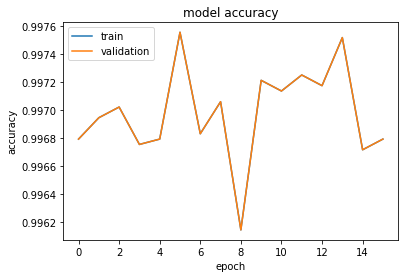

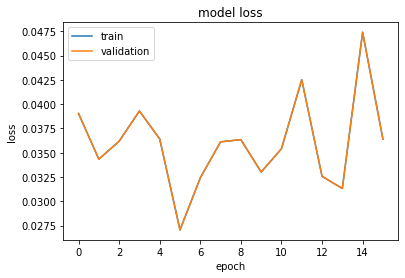

In [65]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [56]:
def plot_training_history(history):
    # Get the classification accuracy and loss-value
    # for the training-set.
    acc = history.history['accuracy']
    loss = history.history['loss']

    # Get it for the validation-set (we only use the test-set).
    val_acc = history.history['accuracy']
    val_loss = history.history['loss']

    # Plot the accuracy and loss-values for the training-set.
    plt.plot(acc, linestyle='-', color='b', label='Training Acc.')
    plt.plot(loss, 'o', color='b', label='Training Loss')
    
    # Plot it for the test-set.
    plt.plot(val_acc, linestyle='--', color='r', label='Test Acc.')
    plt.plot(val_loss, 'o', color='r', label='Test Loss')

    # Plot title and legend.
    plt.title('Training and Test Accuracy')
    plt.legend()

    # Ensure the plot shows correctly.
    plt.show()

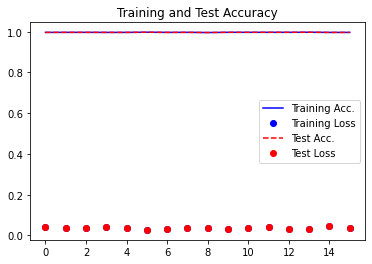

In [57]:
plot_training_history(history)

In [76]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != cls_test)

    # Get the file-paths for images that were incorrectly classified.
    image_paths = np.array(image_paths_test)[incorrect]

    # Load the first 9 images.
    images = load_images(image_paths=image_paths[0:9])
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    
    # Plot the 9 images we have loaded and their corresponding classes.
    # We have only loaded 9 images so there is no need to slice those again.
    plot_images(images=images,
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [77]:


def example_errors():
    # The Keras data-generator for the test-set must be reset
    # before processing. This is because the generator will loop
    # infinitely and keep an internal index into the dataset.
    # So it might start in the middle of the test-set if we do
    # not reset it first. This makes it impossible to match the
    # predicted classes with the input images.
    # If we reset the generator, then it always starts at the
    # beginning so we know exactly which input-images were used.
    test_generator.reset()
    
    # Predict the classes for all images in the test-set.
    y_pred = model.predict(test_generator, steps=32)

    # Convert the predicted classes from arrays to integers.
    cls_pred = np.argmax(y_pred,axis=1)

    # Plot examples of mis-classified images.
    plot_example_errors(cls_pred)
    
    # Print the confusion matrix.
    print_confusion_matrix(cls_pred)

In [78]:
#cls_train = generator_train.classes
cls_test = test_generator.classes

In [79]:
test_dir='test'
image_paths_test = test_generator

In [80]:
example_errors()

/home/noman/anaconda3/envs/tensor2/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


MemoryError: Unable to allocate 76.1 MiB for an array with shape (32, 456, 456, 3) and data type float32

In [ ]:
len(X_train)

In [24]:
X_train.shape

(34279,)

In [25]:
len(Y_train)

34279

In [26]:
Y_train.shape


(34279,)

In [27]:
len(X_val)

8569

In [28]:
X_val.shape

(8569,)

In [29]:
len(Y_val)

8569

In [30]:
Y_val.shape

(8569,)

In [31]:
len(X)

42848

In [32]:
len(Y)

42848

In [33]:
print(classLabels[2])

Strappy


In [35]:
print(classLabels[0])

Background


In [38]:
print(classLabels[1])

Ferny


In [37]:
print(classLabels[3])

Rounded


In [44]:
CLASSES = [ "Amphibolis", "Background", "Halophila","Posidonia",]

predIdxs = model.predict_generator(test_generator)
predIdxs = np.argmax(predIdxs, axis=1)
        
labels = test_generator.labels
        
        # Calculate metrics and confusion matrices for the test images
print(classification_report(labels, predIdxs, target_names=CLASSES))
print(confusion_matrix(labels, predIdxs))
print("Normalized Confusion Matrix")
C = confusion_matrix(labels, predIdxs)
print( C / C.astype(np.float).sum(axis=1, keepdims=True) )

              precision    recall  f1-score   support

  Background       0.96      0.83      0.89      4943
       Ferny       0.86      0.97      0.91      4447
     Rounded       0.89      0.89      0.89      1345
     Strappy       0.92      0.95      0.93      2643

    accuracy                           0.91     13378
   macro avg       0.91      0.91      0.91     13378
weighted avg       0.91      0.91      0.91     13378

[[4087  633   93  130]
 [   0 4324   23  100]
 [ 105   42 1195    3]
 [  46   45   39 2513]]
Normalized Confusion Matrix
[[0.82682581 0.12805988 0.01881449 0.02629982]
 [0.         0.9723409  0.00517203 0.02248707]
 [0.07806691 0.03122677 0.88847584 0.00223048]
 [0.01740446 0.01702611 0.01475596 0.95081347]]


In [56]:
test_path='data/Background/'
test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(img_rows, img_cols),
        batch_size=32,
        class_mode=None,
        shuffle=False) 

Found 0 images belonging to 0 classes.


In [ ]:
CLASSES = [ "Background", "Ferny", "Rounded","Strappy",]
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
predIdxs = model.predict_generator(test_generatorB)
predIdxs = np.argmax(predIdxs, axis=1)
        
labels = test_generator.labels
        
        # Calculate metrics and confusion matrices for the test images
print(classification_report(labels, predIdxs, target_names=CLASSES))
print(confusion_matrix(labels, predIdxs))
print("Normalized Confusion Matrix")
C = confusion_matrix(labels, predIdxs)
print( C / C.astype(np.float).sum(axis=1, keepdims=True) )